Using VGG19 as a backbone to extract features. Each video's frame image is used as an input sequence to an RNN layer. The sequence is classified and we move to the next video. Final classification is whichever inference is highest.

In [2]:
%pylab inline 
#Allows inline plotting.

#General imports.
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.preprocessing.image import img_to_array

import matplotlib.pyplot as plt
import cv2

import imageio

#Importing data.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Populating the interactive namespace from numpy and matplotlib
Mounted at /content/drive


In [3]:
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 100

MAX_SEQ_LENGTH = 200
NUM_FEATURES = 2048

data_path = "/content/drive/MyDrive/Colab Notebooks/Data/VideoData/Augmented"
save_path = "/content/drive/MyDrive/Colab Notebooks/Data/"

In [4]:
train_data_df = pd.read_csv(data_path+"/Train/container.csv",header=None)
train_data_df = train_data_df[train_data_df[0].str.contains("container.csv") == False]
train_data_df = train_data_df[train_data_df[0].str.contains(".ipynb_checkpoints") == False]
print(f"Raw videos for Training: {len(train_data_df)}")

train_data_df.sample(8)

Raw videos for Training: 222


,0,1
167,90W75.mp4,90
61,90W43.mp4,90
90,45W35.mp4,45
29,0W48.mp4,0
164,90W72.mp4,90
209,45W80.mp4,45
76,45W21.mp4,45
80,45W25.mp4,45


In [5]:
val_data_df = pd.read_csv(data_path+"/Val/container.csv",header=None)
val_data_df = val_data_df[val_data_df[0].str.contains("container.csv") == False]
print(f"Raw videos for Validation: {len(val_data_df)}")

val_data_df

Raw videos for Validation: 36


,0,1
0,0W7.mp4,0
1,0W8.mp4,0
2,0W9.mp4,0
3,0W10.mp4,0
4,0W11.mp4,0
5,0W12.mp4,0
6,0W13.mp4,0
7,0W14.mp4,0
8,0W15.mp4,0
9,0W16.mp4,0


In [6]:
test_data_df = pd.read_csv(data_path+"/Test/container.csv",header=None)
test_data_df = test_data_df[test_data_df[0].str.contains("container.csv") == False]
print(f"Raw videos Testing: {len(test_data_df)}")

test_data_df

Raw videos Testing: 21


,0,1
0,0W0.mp4,0
1,0W1.mp4,0
2,0W2.mp4,0
3,0W3.mp4,0
4,0W4.mp4,0
5,0W5.mp4,0
6,0W6.mp4,0
7,90W0.mp4,90
8,90W1.mp4,90
9,90W2.mp4,90


Helper functions for changing the shape of our data.

In [7]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [8]:
def build_feature_extractor():
    feature_extractor = keras.applications.ResNet50(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.resnet50.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 1))
    filter = keras.layers.Conv2D(3,3, padding='same')(inputs)
    preprocessed = preprocess_input(filter)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()


94781440/94765736 [==============================] - 1s 0us/step


In [9]:
feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 3)       30        
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
Total params: 23,587,742
Trainable params: 23,534,622
Non-trainable params: 53,120
________________________________

In [10]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_data_df[1])
)
print(label_processor.get_vocabulary())


['0', '45', '90']


In [11]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df[0].values.tolist()
    labels = df[1].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]

        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                grey_image = tf.image.rgb_to_grayscale(batch[None, j, :])

                temp_frame_features[i, j, :] = feature_extractor.predict(
                    grey_image
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_data_df, "/content/drive/MyDrive/Colab Notebooks/Data/VideoData/Augmented/Train")
val_data, val_labels = prepare_all_videos(val_data_df, "/content/drive/MyDrive/Colab Notebooks/Data/VideoData/Augmented/Val")
test_data, test_labels = prepare_all_videos(test_data_df, "/content/drive/MyDrive/Colab Notebooks/Data/VideoData/Augmented/Test")

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

print(f"Frame features in val set: {val_data[0].shape}")
print(f"Frame masks in val set: {val_data[1].shape}")

print(f"Frame features in test set: {test_data[0].shape}")
print(f"Frame masks in test set: {test_data[1].shape}")

Frame features in train set: (222, 200, 2048)
Frame masks in train set: (222, 200)
Frame features in val set: (36, 200, 2048)
Frame masks in val set: (36, 200)
Frame features in test set: (21, 200, 2048)
Frame masks in test set: (21, 200)


In [12]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(4, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam",metrics=[ "acc"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = "/tmp/video_classifier"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint],
        validation_data=([val_data[0],val_data[1]], val_labels)
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


_, sequence_model = run_experiment()


Epoch 1/100
7/7 [==============================] - ETA: 0s - loss: 1.1290 - acc: 0.3018
Epoch 1: val_loss improved from inf to 1.09862, saving model to /tmp/video_classifier
7/7 [==============================] - 11s 414ms/step - loss: 1.1290 - acc: 0.3018 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 2/100
7/7 [==============================] - ETA: 0s - loss: 1.0980 - acc: 0.3604
Epoch 2: val_loss did not improve from 1.09862
7/7 [==============================] - 0s 60ms/step - loss: 1.0980 - acc: 0.3604 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 3/100
7/7 [==============================] - ETA: 0s - loss: 1.0934 - acc: 0.3649
Epoch 3: val_loss did not improve from 1.09862
7/7 [==============================] - 0s 56ms/step - loss: 1.0934 - acc: 0.3649 - val_loss: 1.0986 - val_acc: 0.3333
Epoch 4/100
7/7 [==============================] - ETA: 0s - loss: 1.0907 - acc: 0.3829
Epoch 4: val_loss improved from 1.09862 to 1.09829, saving model to /tmp/video_classifier
7/7 [=================

In [13]:
print(sequence_model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 200, 2048)]  0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 200)]        0           []                               
                                                                                                  
 gru (GRU)                      (None, 200, 16)      99168       ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 gru_1 (GRU)                    (None, 8)            624         ['gru[0][0]']                

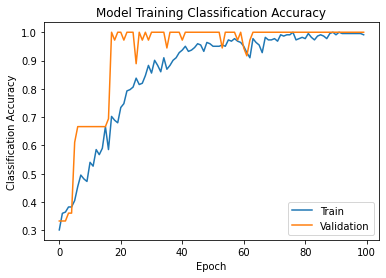

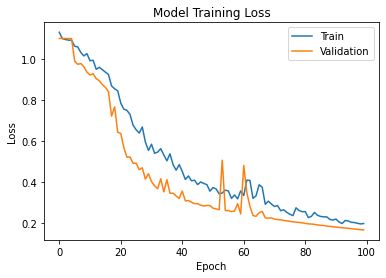

In [15]:
plt.plot(_.history['acc'])
plt.plot(_.history['val_acc'])
plt.title('Model Training Classification Accuracy')
plt.ylabel('Classification Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(_.history['loss'])
plt.plot(_.history['val_loss'])
plt.title('Model Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [16]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            grey_image = tf.image.rgb_to_grayscale(batch[None, j, :])
            frame_features[i, j, :] = feature_extractor.predict(grey_image)
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(path)
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


In [17]:
test_videos = test_data_df[0].values.tolist()

for test_v in test_videos:
  print(f"Test video path: {test_v}")
  test_frames = sequence_prediction(data_path+'/Test/'+test_v)
#to_gif(test_frames[:MAX_SEQ_LENGTH])

Test video path: 0W0.mp4
  0: 99.69%
  90:  0.31%
  45:  0.01%
Test video path: 0W1.mp4
  0: 99.73%
  90:  0.27%
  45:  0.00%
Test video path: 0W2.mp4
  0: 99.72%
  90:  0.28%
  45:  0.00%
Test video path: 0W3.mp4
  0: 99.71%
  90:  0.28%
  45:  0.01%
Test video path: 0W4.mp4
  45: 61.34%
  0: 19.52%
  90: 19.15%
Test video path: 0W5.mp4
  0: 85.41%
  90:  9.79%
  45:  4.80%
Test video path: 0W6.mp4
  0: 97.32%
  90:  2.38%
  45:  0.30%
Test video path: 90W0.mp4
  90: 99.76%
  45:  0.17%
  0:  0.07%
Test video path: 90W1.mp4
  90: 99.69%
  45:  0.28%
  0:  0.03%
Test video path: 90W2.mp4
  90: 99.79%
  45:  0.18%
  0:  0.04%
Test video path: 90W3.mp4
  90: 99.81%
  45:  0.16%
  0:  0.03%
Test video path: 90W4.mp4
  90: 99.86%
  45:  0.12%
  0:  0.02%
Test video path: 90W5.mp4
  90: 99.84%
  45:  0.14%
  0:  0.02%
Test video path: 90W6.mp4
  90: 99.82%
  45:  0.16%
  0:  0.02%
Test video path: 45W0.mp4
  45: 61.34%
  0: 19.52%
  90: 19.15%
Test video path: 45W1.mp4
  45: 61.34%
  0: 19.

**Number 0 Deg Correct and 90 Deg Correct**

In [ ]:
6/7, 7/7, 7/7

**Number of Correct / Incorrect**

In [ ]:
20/21